In [1]:
old_data= '/gpfs/wolf/atm124/proj-shared/gucxprecipradarS2.00/glue_files/'
'/gpfs/wolf2/arm/atm124/world-shared/gucxprecipradarcmacS2.c1/ppi/202208'

'/gpfs/wolf2/arm/atm124/world-shared/gucxprecipradarcmacS2.c1/ppi/202208'

In [2]:
import pyart
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import sys
import fiona
import geopandas as gpd
#fiona.drvsupport.supported_drivers['lib?kml'] = 'rw' # enable KML support which is disabled by default
#fiona.drvsupport.supported_drivers['LIBKML'] = 'rw' # enable KML support which is disabled by default



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
ERROR 1: PROJ: proj_create_from_database: Open of /ccsopen/home/braut/analysis-env2/share/proj failed
/ccsopen/home/braut/analysis-env2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
hour = '19'
day = '25'
month = '08'
year = '2022'

#glob_str = f'/gpfs/wolf/atm124/proj-shared/gucxprecipradarS2.00/glue_files/{year}{month}_glued/xprecipradar_guc_volume_{year}{month}{day}-{hour}*'
glob_str = f'/gpfs/wolf2/arm/atm124/world-shared/gucxprecipradarcmacS2.c1/ppi/{year}{month}/gucxprecipradarcmacS2.c1.{year}{month}{day}.{hour}*'

files = sorted(glob.glob(glob_str))
files

['/gpfs/wolf2/arm/atm124/world-shared/gucxprecipradarcmacS2.c1/ppi/202208/gucxprecipradarcmacS2.c1.20220825.190443.nc',
 '/gpfs/wolf2/arm/atm124/world-shared/gucxprecipradarcmacS2.c1/ppi/202208/gucxprecipradarcmacS2.c1.20220825.191043.nc',
 '/gpfs/wolf2/arm/atm124/world-shared/gucxprecipradarcmacS2.c1/ppi/202208/gucxprecipradarcmacS2.c1.20220825.191643.nc',
 '/gpfs/wolf2/arm/atm124/world-shared/gucxprecipradarcmacS2.c1/ppi/202208/gucxprecipradarcmacS2.c1.20220825.192243.nc',
 '/gpfs/wolf2/arm/atm124/world-shared/gucxprecipradarcmacS2.c1/ppi/202208/gucxprecipradarcmacS2.c1.20220825.192843.nc',
 '/gpfs/wolf2/arm/atm124/world-shared/gucxprecipradarcmacS2.c1/ppi/202208/gucxprecipradarcmacS2.c1.20220825.193443.nc',
 '/gpfs/wolf2/arm/atm124/world-shared/gucxprecipradarcmacS2.c1/ppi/202208/gucxprecipradarcmacS2.c1.20220825.194043.nc',
 '/gpfs/wolf2/arm/atm124/world-shared/gucxprecipradarcmacS2.c1/ppi/202208/gucxprecipradarcmacS2.c1.20220825.194643.nc',
 '/gpfs/wolf2/arm/atm124/world-shared/gu

In [45]:
radar = pyart.io.read(files[3])
radar = radar.extract_sweeps(sweeps=[0])

In [46]:
radar

(-20.0, 20.0)

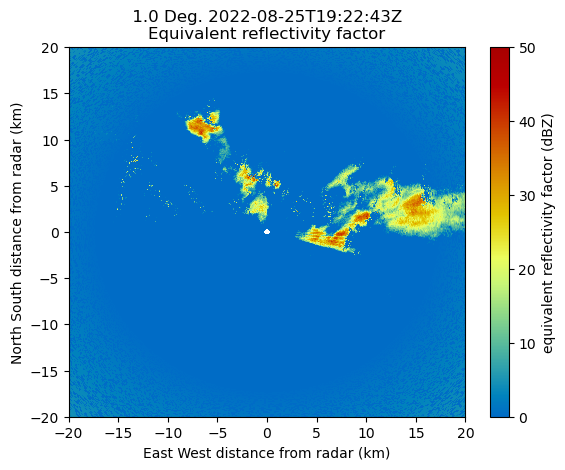

In [47]:
display = pyart.graph.RadarDisplay(radar)
display.plot('DBZ', vmin=0, vmax=50) #DBZ corrected_reflectivity
plt.xlim(-20, 20)
plt.ylim(-20, 20)

In [48]:
def texture(radar):
    nyquist_value = radar.fields['VEL']['data'].max()
    vel_texture = pyart.retrieve.calculate_velocity_texture(radar,
                                                        vel_field='VEL',
                                                        nyq=nyquist_value)

    radar.add_field('velocity_texture', vel_texture, replace_existing=True)

    phidp_texture = pyart.retrieve.texture_of_complex_phase(radar, phidp_field='PHIDP', phidp_texture_field='phidp_texture')

    radar.add_field('phidp_texture', phidp_texture, replace_existing=True)
    return radar

radar = texture(radar)

(-20.0, 20.0)

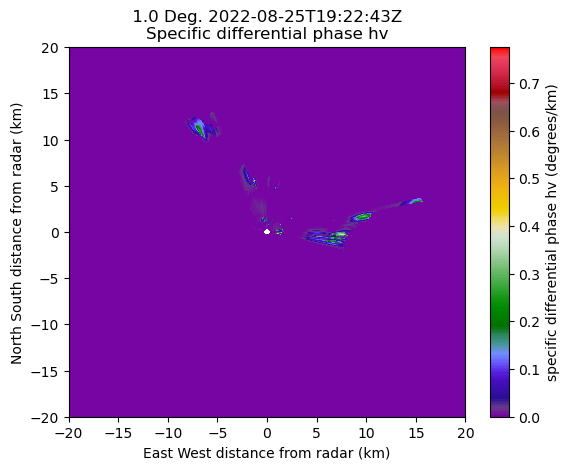

In [51]:
display = pyart.graph.RadarDisplay(radar)
display.plot('filtered_corrected_specific_diff_phase', cmap='pyart_Carbone42') #DBZ
plt.xlim(-20, 20)
plt.ylim(-20, 20)

In [14]:

PHIDP_LP, KDP_LP = pyart.correct.phase_proc_lp(radar, 0.0, ncp_field='NCP', refl_field='DBZ', rhv_field='RHOHV', phidp_field='PHIDP')
radar.fields['PHIDP_LP']=PHIDP_LP
radar.fields['KDP_LP']=KDP_LP


In [16]:
PHIDP_LP, KDP_LP = pyart.correct.phase_proc_lp(radar, 0.0, ncp_field='NCP', refl_field='corrected_reflectivity', rhv_field='RHOHV', phidp_field='corrected_differential_phase')
radar.fields['PHIDP_LPc']=PHIDP_LP
radar.fields['KDP_LPc']=KDP_LP

/ccsopen/home/braut/analysis-env2/lib/python3.10/site-packages/pyart/correct/phase_proc.py:171: RuntimeWarning: divide by zero encountered in divide
  return abs(signal) / _noise


In [69]:


kdp, _for_kdp, r_kdp = pyart.retrieve.kdp_maesaka(radar, refl_field='corrected_reflectivity',
                                                  psidp_field='corrected_differential_phase')

radar.fields['KDP_maesaka']=kdp


In [47]:
radar.info()

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	_FillValue: -9999.0
	long_name: Altitude
	units: m
	standard_name: altitude
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float32 and shape: (1158,)>
	long_name: Azimuth Angle from True North
	axis: radial_azimuth_coordinate
	units: degree
	standard_name: sensor_to_target_azimuth_angle
elevation:
	data: <ndarray of type: float32 and shape: (1158,)>
	long_name: Elevation angle from horizontal plane
	axis: radial_elevation_coordinate
	units: degree
	standard_name: sensor_to_target_elevation_angle
fields:
	DBZ:
		data: <ndarray of type: float64 and shape: (1158, 668)>
		_FillValue: -32768.0
		units: dBZ
		standard_name: equivalent_reflectivity_factor
		coordinates: elevation azimuth range
		long_name: Equaivalent_radar_reflectiivity_factor
	VEL:
		data: <ndarray of type: float64 and shape: (1158, 668)>
		_FillValue: -32768.0
		units: m/s
		standard_name: radial_velocity_of_scatterers_away_from_ins